## 지정 주제

### 자신의 인생 영화를 1개 선정하고, Daum 영화에서 해당 영화의 리뷰를 이용하여 워드클라우드 그리기 & 분류기 학습 시키기

## 인생영화로 `하울의 움직이는 성`을 선택한 이유

### 개인적인 이유
언제 들어도 질리지 않는 멋진 배경음악도 좋고,  
영화 곳곳에 숨겨진 복선을 찾는 재미도 쏠쏠하며,  
무엇보다도 **하울이 잘생겼기 때문이다.**

### 기술적인 이유
`하울의 움직이는 성` 의 Daum 영화 평점은 2022년 12월 9일 기준 총 903명이 평가했다.  
댓글 없이 평점만 등록한 건을 제외하면 평가 건수가 더 적을 것으로 예상한다.  
그럼에도 불구하고, `naive-bayes 분류기`가 긍정/부정을 잘 학습할 수 있을지 호기심이 생겨 해당 영화를 선택하였다.


### 개발환경

![OS](https://img.shields.io/badge/OS-macOS%20Monterey-lightgrey)
![Language](https://img.shields.io/badge/Language-Python-%234B8BBE)
![Platform](https://img.shields.io/badge/Platform-Jupyter-%23EB7425)
![Library](https://img.shields.io/badge/Library-Matplotlib-%23306998)
![Library](https://img.shields.io/badge/Library-pandas-%23150554)

## `selenium` 으로 영화 `하울의 움직이는 성` 링크 가져오기

In [1]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk

driver = webdriver.Chrome(r"C:\Users\SH501\Downloads\chromedriver_win32\chromedriver.exe")

url = "https://movie.daum.net/moviedb/grade?movieId=39208"
driver.get(url)

/var/folders/55/36xc75rd0s3fd8vsc5bzwfh80000gn/T/ipykernel_34464/3246421736.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"C:\Users\SH501\Downloads\chromedriver_win32\chromedriver.exe")


## `평점 더보기` 를 클릭하여 모든 리뷰 보기

In [2]:
while(True):
    try:
        time.sleep(2)
        driver.find_element("xpath", '/html/body/div[2]/main/article/div/div[2]/div[2]/div/div/div[2]/div/div/div/div[3]/div[1]/button[1]').click()
    except:
        break

## 현재 페이지 소스를 저장하고
## 파싱을 위해 `BeautifulSoup` 으로 가져오기

In [3]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

## `list_comment` 내 감상평과 평점 가져오기

In [4]:
train_txt = []      # 감상평 저장
train_ratings = []  # 평점 저장

result = soup.find("ul", {"class": "list_comment"})
li_result = result.find_all("li")

for li_res in result:
    desc_txt = li_res.find("p")
    if desc_txt == None: # 감상평 없이 평점만 있다면
        continue         # 리스트에 저장하지 않고 넘긴다.
    else:
        desc_txt = li_res.find("p").text
        rating = int(li_res.find("div", {'class': 'ratings'}).text)
        
        train_txt.append(desc_txt)
        train_ratings.append(rating)

#train_txt

## 명사 추출

In [5]:
from konlpy.tag import Okt

okt = Okt()

train_txt_noun = okt.nouns(str(train_txt))

## `Stopword` 제거하기
한 글자인 단어를 모두 제거하려고 했으나,  
`짱`, `굿`, `또`, `좀` 등 한 글자 자체만으로 긍정을 나타내는 경우도,   
긍정적인, 혹은 부정적인 단어와 함께 쓰이는 한 글자짜리 형식형태소도 있었다.  
특수기호나 개행 문자의 경우, `okt.nouns` 을 통해 모두 배제하였기 때문에  
별도의 stopword 없이 프로젝트를 진행했다.

In [6]:
#stopword_list = ['이', '그', '저', '것']

#for word in train_txt_noun:
#    if len(word) == 1:
#        stopword_list.append(word)

#for stopword in stopword_list:
#    if stopword in train_txt_noun:
#        train_txt_noun.pop(train_txt_noun.index(stopword))
#len(train_txt_noun)

## 빈도수를 고려한 전체리뷰 워드클라우드 만들기

1154


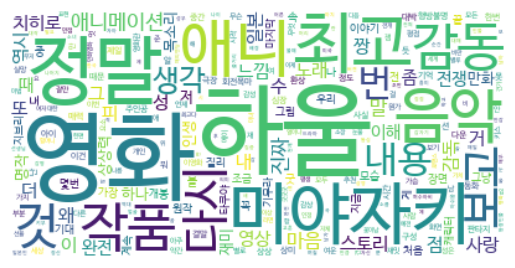

In [7]:
from wordcloud import WordCloud
from collections import Counter

wc = WordCloud(background_color='white', max_words=2000, font_path='/Library/Fonts/NanumBarunGothic.ttf')
count = Counter(train_txt_noun)
print(len(count))
wc = wc.generate_from_frequencies(count)

import matplotlib.pyplot as plt
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 분류기 학습 시키기

In [8]:
train_txt_np = []       # 8점을 제외한 감상평 저장
train_ratings_np = []   # 8점을 제외한 평점을 pos, neg 형태로 저장
txt_pos = []            # 긍정 워드클라우드를 만들기 위해 저장한다.
txt_neg = []            # 부정 워드클라우드를 만들기 위해 저장한다.
count_pos = 0           # 긍정 카운트
count_neg = 0           # 부정 카운트
count_index = 0

for i in train_ratings:              # 수집하는 긍정 및 부정 비율을 동일하게 맞췄다. 긍정: 587, 부정: 87개 이므로 80으로 맞췄다. 
    if (i >= 0 and i <= 7) and (count_neg < 80): # 10점 만점에 7점은 중간값인 5보다 높기 때문에 긍정적인 평가로 보일 수 있으나,
        #print(i)                                # 실제로 감상평을 살펴보면 그렇지 않다.
        train_ratings_np.append('neg')           # 따라서 부정적인 평가의 기준을 기존의 분류기와 다르게 변경하였다.
        train_txt_np.append(train_txt[count_index])
        txt_neg.append(train_txt[count_index])
        count_neg = count_neg + 1
        count_index = count_index + 1
        
    elif (i == 9 or i == 10) and (count_pos < 80):
        #print(i)
        train_ratings_np.append('pos')
        train_txt_np.append(train_txt[count_index])
        txt_pos.append(train_txt[count_index])
        count_pos = count_pos + 1
        count_index = count_index + 1

        
    elif (i == 8): # 8점일 경우, 긍정도 부정도 아니기 때문에 해당 감상평은 저장하지 않는다.
        #print("pass")
        count_index = count_index + 1
print(count_pos, count_neg)

80 80


## 긍정 워드클라우드 만들기

180


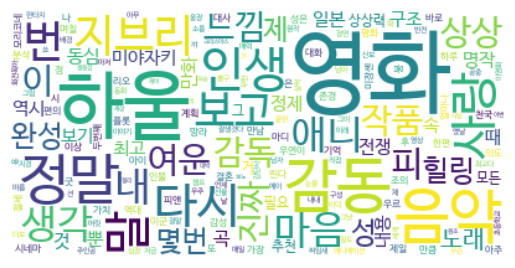

In [9]:
train_txt_pos = okt.nouns(str(txt_pos))

wc_pos = WordCloud(background_color='white', max_words=2000, font_path='/Library/Fonts/NanumBarunGothic.ttf')
count = Counter(train_txt_pos)
print(len(count))
wc_pos = wc.generate_from_frequencies(count)

import matplotlib.pyplot as plt
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 부정 워드클라우드 만들기

293


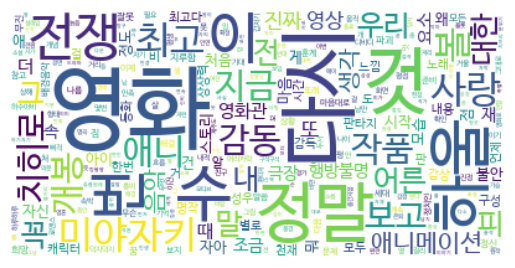

In [10]:
train_txt_neg = okt.nouns(str(txt_neg))

wc_neg = WordCloud(background_color='white', max_words=2000, font_path='/Library/Fonts/NanumBarunGothic.ttf')
count = Counter(train_txt_neg)
print(len(count))
wc_neg = wc.generate_from_frequencies(count)

import matplotlib.pyplot as plt
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 워드클라우드 결과 해석

### 워드클라우드 해석 (공통)
`부정적` 인 감상평의 기준을 넓게 잡았음 <sub>(1-4점 에서 0-7점 사이로 변경)</sub> 에도 불구하고,  
`긍정적` 인 키워드가 `부정적` 인 키워드의 **두 배 이상**이다.  
`하울의 움직이는 성` 은 대체적으로 **긍정적인 평가**를 받고 있는 영화이며,  
호불호가 갈리는 영화라고 보기 어렵다.  

세 워드클라우드에서 모두 `하울` 이라는 키워드가 자주 등장했다.  
`하울의 움직이는 성` 이라는 영화 제목 자체를 언급하기 위해, 또는 주인공 이름인 `하울`을 언급하기 위해서인 것으로 보인다.  
또한, `하울` 의 외모를 칭찬하는 평가가 `긍정적` 감상평에도, `부정적` 감상평에도 많았다.  
또다른 주인공인 `소피` 는 의외로 자주 언급되지 않았는데, 누리꾼들이 `하울`의 외모가 너무 인상깊었던 나머지  
`소피`의 활약에 집중하지 못한 것으로 보인다. 

### 긍정 워드클라우드 해석
`명작`, `최고`, `감동`, `짱` 등 **긍정적 키워드임을 직관적으로 나타내는** 단어가 많다.  
`질리` 라는 단어가 부정적인 키워드처럼 보이지만, `질리지 않는~` 등의 긍정적 어구를 형태소 분석한 일부분으로 보인다.  
이 영화의 OST인 `인생의 회전목마` 가 형태소 분석을 거쳐 `인생` 과 `회전목마` 로 분리되어 나타난 점도 흥미롭다.


### 부정 워드클라우드 해석
긍정 워드클라우드에 비해 직관적으로 보이는 **부정적 키워드가 적다.**  
*싫다* 등과 같이 직접적으로 표현하기보다는 **간접적으로 부정적인 감상평을 남긴다**는 사실을 유추할 수 있다.  
긍정 워드클라우드와 비교했을 때 `미야자키` 가 더 많이 언급된 것을 볼 수 있다.  
원작자인 `미야자키 하야오` 의 작품인 `하울의 움직이는 성` 에 많은 기대를 했으나,  
'`미야자키 하야오` 스럽지 못한 영화였다' 라는 감상평이 많았기 때문이다.  
`치히로` 도 긍정 워드클라우드에 비해 많이 언급되었다.  
`미야자키 하야오`의 다른 작품인 '센과 치히로의 행방불명'과 비교 및 대조하여 쓴 감상평이 많았기 때문이다.

## 긍정/부정으로 분류하는 분류기 학습시키기

In [11]:
import math

class MyNaiveBayesClassifier:
    def __init__(self, k=0.5, use_morph=False): # 객체 초기화 메서드
        self.k = k
        self.word_probs = []
        self.use_morph = use_morph
        
        if self.use_morph:
            from konlpy.tag import Okt
            okt = Okt()
            
    def load_data(self, txt, ratings): # 미리 가공해 둔 데이터를 이용하기 때문에 별다른 절차가 없어도 된다.
        
        return txt, ratings
    
    def tokenize(self, sentence): # 문장 토큰화하기
        if self.use_morph:
            pos_sent = []

            sent = okt.pos(sentence, norm=True, stem=True)
            for tup in sent:
                word, tag = tup
                word_tag = word + '/' + tag
                pos_sent.append(word_tag)

            sentence = ' '.join(pos_sent) 
        
        return sentence.split()
    
    def count_words(self, docs, labels): # 단어 등장 횟수 세기, 긍정/부정 횟수 세기
        count_dict = dict()
        for doc, label in zip(docs, labels):
            for word in self.tokenize(doc):
                if word not in count_dict:
                    count_dict[word] = {'pos':0, 'neg':0}
                count_dict[word][label] += 1
                
        print('num of words...', len(count_dict))
        
        return count_dict
    
    def word_prob(self, count_dict, pos_class_num, neg_class_num, k): # 단어 확률 계산하기
        word_prob_list = []         # 라플라스 스무딩(Laplace smoothing) 이용 ->
                                    # 분모, 분자에 일정한 값(Ex. 0.5)를 더해서 분자가 0이 되는 것을 방지
        for word in count_dict:     # 문장에 사용된 단어 중 한 개의 단어라도 학습데이터에 없을 경우, 전체 확률이 0이 되어버리는 상황 방지
            pos_word_num = count_dict[word]['pos']
            neg_word_num = count_dict[word]['neg']
            
            pos_class_prob = (pos_word_num + k) / (pos_class_num + 2*k)
            neg_class_prob = (neg_word_num + k) / (neg_class_num + 2*k)
        
            tup = (word, pos_class_prob, neg_class_prob) # 튜플 형태로 만들어
            word_prob_list.append(tup)                   # 리스트에 추가 
            
        return word_prob_list
    
    def class_prob(self, word_prob_list, test_sentence, use_unseen=False): # p(긍정|문서), p(부정|문서) 계산
        test_words = self.tokenize(test_sentence)
        
        sent_log_pos_class_prob, sent_log_neg_class_prob = 0, 0
        
        for word, word_pos_class_prob, word_neg_class_prob in word_prob_list:
            if word in test_words:
                sent_log_pos_class_prob += math.log(word_pos_class_prob)
                sent_log_neg_class_prob += math.log(word_neg_class_prob)
            else:
                if use_unseen:
                    sent_log_pos_class_prob += math.log(1-word_pos_class_prob)
                    sent_log_neg_class_prob += math.log(1-word_neg_class_prob)
        
        sent_pos_class_prob = math.exp(sent_log_pos_class_prob)
        sent_neg_class_prob = math.exp(sent_log_neg_class_prob)
        
        pos_class_prob = sent_pos_class_prob / (sent_pos_class_prob+sent_neg_class_prob)
        neg_class_prob = sent_neg_class_prob / (sent_pos_class_prob+sent_neg_class_prob)
        
        return pos_class_prob, neg_class_prob 
    
    def train(self, txt, ratings): # load_data, count_words, word_prob 수행
        train_docs, train_labels = txt, ratings
        
        word_count_dict = self.count_words(train_docs, train_labels)
        
        pos_class_num = 0
        neg_class_num = 0
        for label in train_labels:
            if label == 'pos':
                pos_class_num += 1
            else: 
                neg_class_num += 1
                
        
        self.word_probs = self.word_prob(word_count_dict, pos_class_num, neg_class_num, self.k)
        
    def classify(self, doc, use_unseen=False): # class_prob 계산
        pos_class_prob, neg_class_prob = self.class_prob(self.word_probs, doc, use_unseen)
        
        if pos_class_prob > neg_class_prob:
            print('pos', pos_class_prob)
        else:
            print('neg', neg_class_prob)
            

In [12]:
classifier = MyNaiveBayesClassifier()

In [13]:
classifier.train(train_txt_np, train_ratings_np)

num of words... 933


## Test 문장을 입력하여 분류기 결과 확인해보기

In [14]:
classifier.classify('인생 영화!! 믿고 보는 지브리! 역시 하울은 잘생겼다', use_unseen=False)

pos 0.9782608695652174


In [15]:
driver.close()

## 느낀 점 및 자기평가

감상평 수가 적다고 생각하여 긍정 및 부정 데이터의 상대적인 양을 **고려하지 않고** 최대한 많은 데이터를 확보하고자 했다.  
그 결과 분류기가 제대로 학습하지 못했고, 구현한 분류기는 **세상에서 가장 부정적인 마인드를 가진** 프로그램이 되어버렸다.  
긍정적인 데이터와 부정적인 데이터의 **비율을 고려**하여 수집하는 양을 동일하게 맞춰 주었더니 잘 작동했다.  

전체적인 **감상평 수**, 감상평 내에 심심찮게 등장하는 **오탈자**, 전체 맥락을 파악해야만 숨은 뜻이 보이는 **간접적인 감상평** 등이 변수였다.  
분류기를 학습시킬 때,`나만 볼꼬얌` 이라는 감상평이 있었다.  
`볼꼬얌` 이 표준어가 아님은 물론, `나만 볼꼬얌` 에는 "이 영화는 매우 좋은 영화이므로 **나만 봐야겠다**" 라는 의미가 담겨있다.  
**긍정적**인 감상평임에도 불구하고 해당 감상평의 평점은 **1점**이었다. 이 영화를 안좋게 평가해서 본인만 영화를 볼 것이라는 의도가 담겨있다.  
`~겠다` 등의 쌍시옷 받침을 사용하는 데이터의 경우 `~겟다` 와 같이 **오타를 수정하지 않은 채** 그대로 감상평을 작성하는 경우도 있었다.

단순히 형태소를 분석해 긍정과 부정을 나누는 것을 넘어  
문장 전체의 **맥락**을 파악하고, **오탈자**는 없는지, 있다면 그 **오탈자는 어떤 표준어를 쓰려다 난 것**인지 등을 파악할 수 있다면  
더욱 매끄럽고 정확한 분석을 할 수 있을 것으로 보인다.